# Task – Projective Transformation (Homography)

## a) Image acquisition: 

Take three pictures with a digital camera, which have at least 30% overlap in horizontal direction. Make sure to not capture disparities, e.g by turning around the projection center or choosing a planar object as motif.

In [6]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
img_1 = cv2.cvtColor(cv2.imread("1.jpg"), cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread("2.jpg"), cv2.COLOR_BGR2RGB)
img_3 = cv2.cvtColor(cv2.imread("3.jpg"), cv2.COLOR_BGR2RGB)

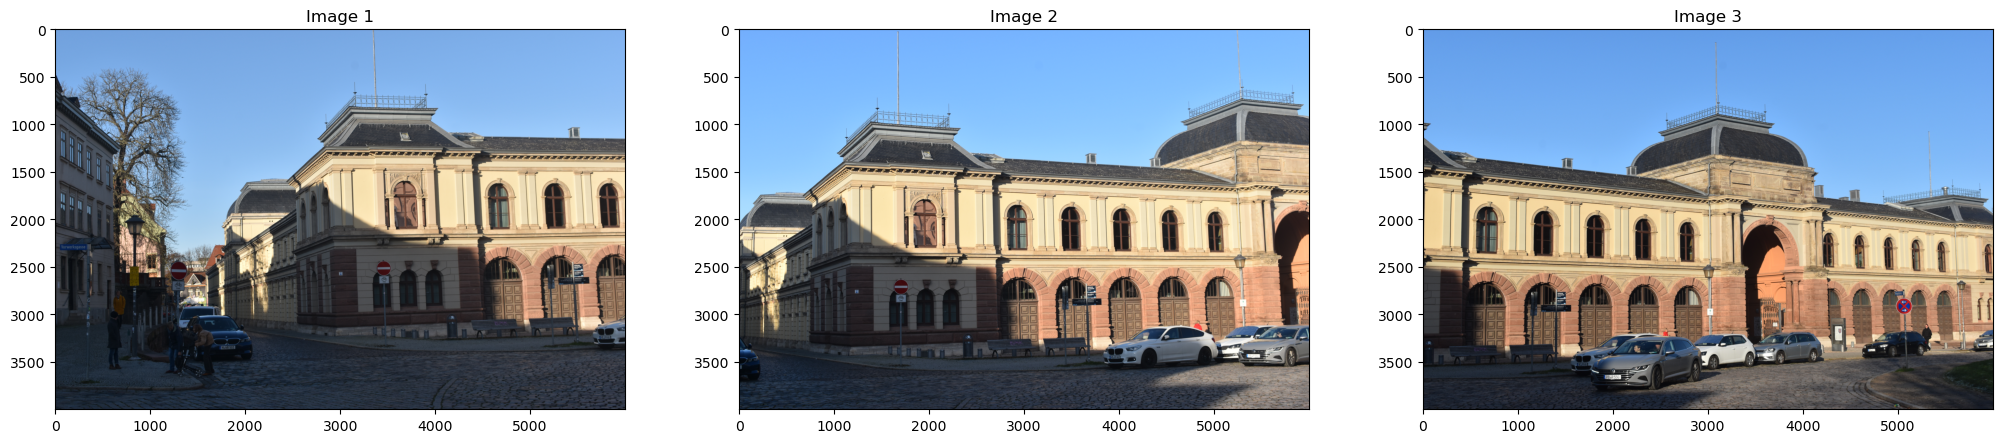

In [3]:
plt.figure(figsize = (25,25))
plt.subplot(1,3,1)
plt.imshow(img_1)
plt.title("Image 1")
plt.subplot(1,3,2)
plt.imshow(img_2)
plt.title('Image 2')
plt.subplot(1,3,3)
plt.imshow(img_3)
plt.title('Image 3')
plt.show()

## Homography computation

Implement your own function in order to estimate a 2D homography using the singular value decomposition (mean, abs, svd, reshape). Compute the homography matrix H12 from the first to the second image.

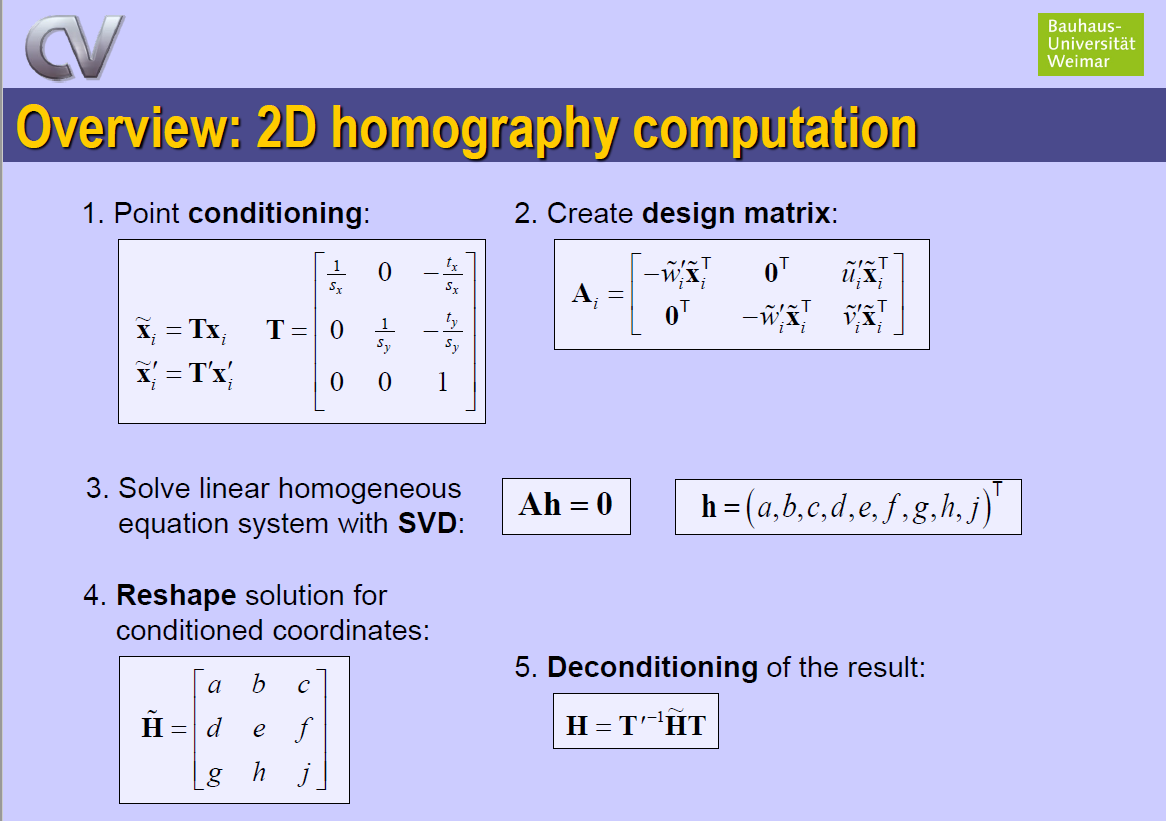

In [4]:
def transformation(x):
    # tx and ty
    tx = x[0,:].mean()
    ty = x[1,:].mean()
    # sx and sy
    sx = (abs(x[0,:]-tx)).mean()
    sy = (abs(x[1,:]-ty)).mean()
    # Coordinate transformation
    T = [[1/sx,  0,      -tx/sx],
        [0,    1/sy,   -ty/sy],
        [0,    0,      1]]
    
    return np.array(T)

# Design Matrix
def design_matrix_calc(x1_transformed,x2_transformed):
    A = np.zeros([2,9])

    for i in range(x1_transformed.shape[1]):
        w_i_x_i_i = (x2_transformed[2][i])*(x1_transformed.T[i])
        u_i_x_i_i = (x2_transformed[0][i])*(x1_transformed.T[i])
        v_i_x_i_i = (x2_transformed[1][i])*(x1_transformed.T[i])

        A_i =np.array([[-w_i_x_i_i[0],-w_i_x_i_i[1],-w_i_x_i_i[2],0,0,0,u_i_x_i_i[0],u_i_x_i_i[1],u_i_x_i_i[2]],
                       [0,0,0,-w_i_x_i_i[0],-w_i_x_i_i[1],-w_i_x_i_i[2],v_i_x_i_i[0],v_i_x_i_i[1],v_i_x_i_i[2]]])

        A = np.vstack((A,A_i))
    
    design_matrix = np.vstack(((np.delete(A,[0,1], 0)),np.zeros([1,9])))

    return design_matrix

def Homography(x1,x2):
    # point conditioning
    Transformation1=transformation(x1)
    Transformation2=transformation(x2)
    x1_transformed = np.matmul(Transformation1,x1)
    x2_transformed = np.matmul(Transformation2,x2)
    design_matrix = design_matrix_calc(x1_transformed,x2_transformed)
    Homography_conditioned = SVD_solv(design_matrix).reshape((3, 3))
    # Homography = np.linalg.inv(T2)*Homography_conditioned*T1
    Homography = np.matmul(np.matmul(np.linalg.inv(Transformation2),Homography_conditioned),Transformation1)
    return Homography

# Singular value decomposition
def SVD_solv(design_matrix):
# u, s, vh = np.linalg.svd(d, full_matrices=True)
    U, S, V = svd(design_matrix)
    # return last row of V
    return V[-1]

# Final Source Code

In [ ]:
import sys
import matplotlib
matplotlib.use('Qt5Agg')
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import svd
from scipy.ndimage import map_coordinates


def geokor(H, f, g):
    """
    Warps image into g according to homography transformation H.
    :param H: 3x3 homography transformation matrix
    :param f: source image
    :param g: target image
    :return: image containing g and warped f.

    Example call of the GEOKOR function
    -------------------------------------------
    f = cv2.imread("image1.ppm", cv2.IMREAD_COLOR)
    g = cv2.imread("image2.ppm", cv2.IMREAD_COLOR)
    H = np.array([[0.60555828, -0.01754050, -151.35724626],
                  [0.10833625, 0.58131888, -31.30960606],
                  [0.00058744, 0.00013177, 0.35639124]])
    i = geokor(H, f, g)  # Transform image f using H and combine with g
    plt.imshow(i)
    plt.show()
    """
    # images dimensions
    h1, w1, d = f.shape
    h2, w2, _ = g.shape

    # transform corner points
    cp = np.array([[1, 1, w1, w1],
                   [1, h1, 1, h1],
                   [1, 1, 1, 1]])
    cp = H.dot(cp)
    cp = cp / cp[-1, :]  # dehomogenize

    # determine resulting size
    Xpr = np.arange(min(cp[0, ...].min(), 0), max(cp[0, ...].max(), w2))
    Ypr = np.arange(min(cp[1, ...].min(), 0), max(cp[1, ...].max(), h2))
    Xp, Yp = np.meshgrid(Xpr, Ypr, indexing="ij")
    wp, hp = Xp.shape

    # indirect transform (from target to source)
    X = np.linalg.inv(H).dot(np.array([Xp.flatten(order='F'), Yp.flatten(order='F'), np.ones((wp * hp,))]))
    X /= X[-1, :]

    # resample intensities from source to target
    i = np.zeros((hp, wp, d))
    for k in range(3):
        i[..., k] = map_coordinates(f[..., k], [X[1, :], X[0, :]]).reshape(hp, wp)

    # paste (unwarped) target image
    off = -np.round([Ypr[0], Xpr[0]]).astype(int)
    nz = np.nonzero(g)
    i[nz[0] + off[0], nz[1] + off[1], nz[2]] = g[nz]

    # clip and convert
    i = np.uint8(np.clip(i, 0, 255))
    return i

def transformation(x):
    # tx and ty
    tx = x[0,:].mean()
    ty = x[1,:].mean()
    # sx and sy
    sx = (abs(x[0,:]-tx)).mean()
    sy = (abs(x[1,:]-ty)).mean()
    # Coordinate transformation
    T = [[1/sx,  0,      -tx/sx],
        [0,    1/sy,   -ty/sy],
        [0,    0,      1]]
    
    return np.array(T)

# Design Matrix
def design_matrix_calc(x1_transformed,x2_transformed):
    A = np.zeros([2,9])

    for i in range(x1_transformed.shape[1]):
        w_i_x_i_i = (x2_transformed[2][i])*(x1_transformed.T[i])
        u_i_x_i_i = (x2_transformed[0][i])*(x1_transformed.T[i])
        v_i_x_i_i = (x2_transformed[1][i])*(x1_transformed.T[i])

        A_i =np.array([[-w_i_x_i_i[0],-w_i_x_i_i[1],-w_i_x_i_i[2],0,0,0,u_i_x_i_i[0],u_i_x_i_i[1],u_i_x_i_i[2]],
                       [0,0,0,-w_i_x_i_i[0],-w_i_x_i_i[1],-w_i_x_i_i[2],v_i_x_i_i[0],v_i_x_i_i[1],v_i_x_i_i[2]]])

        A = np.vstack((A,A_i))
    
    design_matrix = np.vstack(((np.delete(A,[0,1], 0)),np.zeros([1,9])))

    return design_matrix

def Homography(x1,x2):
    Transformation1=transformation(x1)
    Transformation2=transformation(x2)
    x1_transformed = np.matmul(Transformation1,x1)
    x2_transformed = np.matmul(Transformation2,x2)
    design_matrix = design_matrix_calc(x1_transformed,x2_transformed)
    Homography_conditioned = SVD_solv(design_matrix).reshape((3, 3))
    # Homography = np.linalg.inv(T2)*Homography_conditioned*T1
    Homography = np.matmul(np.matmul(np.linalg.inv(Transformation2),Homography_conditioned),Transformation1)
    return Homography

def SVD_solv(design_matrix):
# Singular value decomposition

# u, s, vh = np.linalg.svd(d, full_matrices=True)
    U, S, V = svd(design_matrix)
    # return last row of V
    return V[-1]


# plt.imshow(final_image)
def print_photos(img_1,img_2,img_3,final_image):
    plt.figure(figsize=(25, 25))
    plt.subplot(1, 4, 1)
    plt.imshow(img_1)
    plt.title("image_1")
    plt.subplot(1, 4, 2)
    plt.imshow(img_1)
    plt.title("image_2")
    plt.subplot(1, 4, 3)
    plt.imshow(img_3)
    plt.title("image_3")
    plt.subplot(1, 4, 4)
    plt.imshow(final_image)
    plt.title('final_image')
    plt.savefig("final_image.png")
    plt.show()


def panorama(img_1,img_2):
    plt.figure(figsize= (10,10))
    plt.imshow(img_1)
    clicks1 = np.array(plt.ginput(4)) # Will record four clicks.
    x1 = np.transpose(np.append(np.array(clicks1), np.ones((4,1)), axis=1))
    plt.close()

    plt.figure(figsize= (10,10))
    plt.imshow(img_2)
    clicks2 = plt.ginput(4) # Will record four clicks.
    x2 = np.transpose(np.append(np.array(clicks2), np.ones((4,1)), axis=1))
    plt.close()
    Homography_matrix = Homography(x1, x2) 
    
    i = geokor(Homography_matrix, img_1, img_2)
    return i
    
    
img_1 = cv2.cvtColor(cv2.imread("1.jpg"), cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(cv2.imread("2.jpg"), cv2.COLOR_BGR2RGB)
img_3 = cv2.cvtColor(cv2.imread("3.jpg"), cv2.COLOR_BGR2RGB)
# final_image = panorama(img_3,panorama(img_1,img_2))

image_1_2 = panorama(img_1,img_2)
# plt.imshow(image_1_2)
# plt.show()
final_image = panorama(image_1_2,img_3)
# final_image = panorama(img_3,panorama(img_1,img_2))
# final_image = panorama(img_1,img_2)

print_photos(img_1,img_2,img_3,final_image)


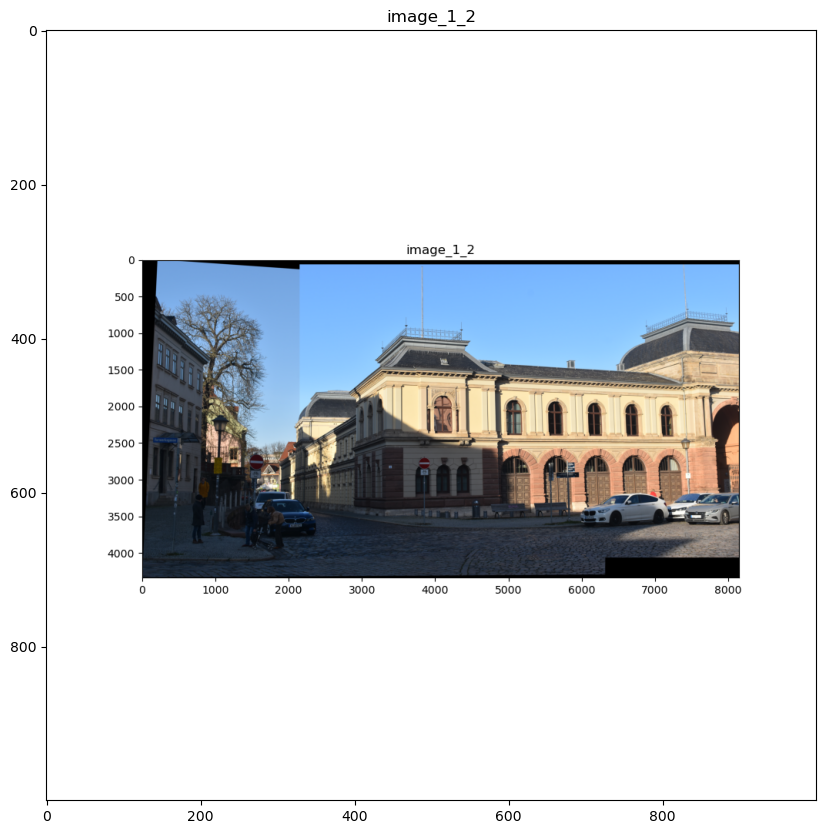

In [3]:
plt.figure(figsize= (10,10))
plt.imshow(image_1_2)
plt.title("image_1_2")
plt.savefig("image_1_2.png")
plt.show()

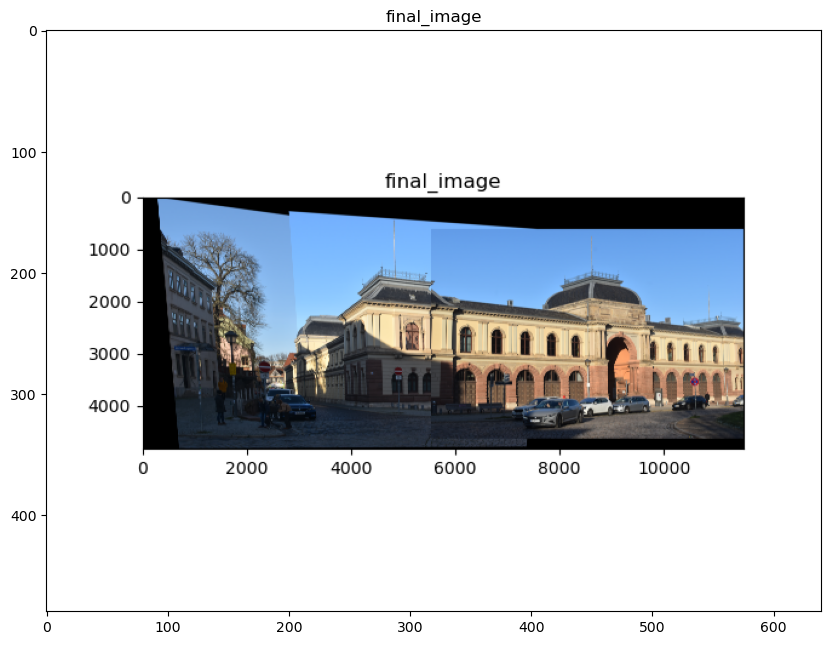

In [5]:
plt.figure(figsize= (10,10))
plt.imshow(final_image)
plt.title("final_image")
plt.savefig("final_image.png")
plt.show()